<a href="https://colab.research.google.com/github/rounak393/imageprocessing/blob/main/Midas_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading weights:  None


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.

Saving input.jpg to input.jpg


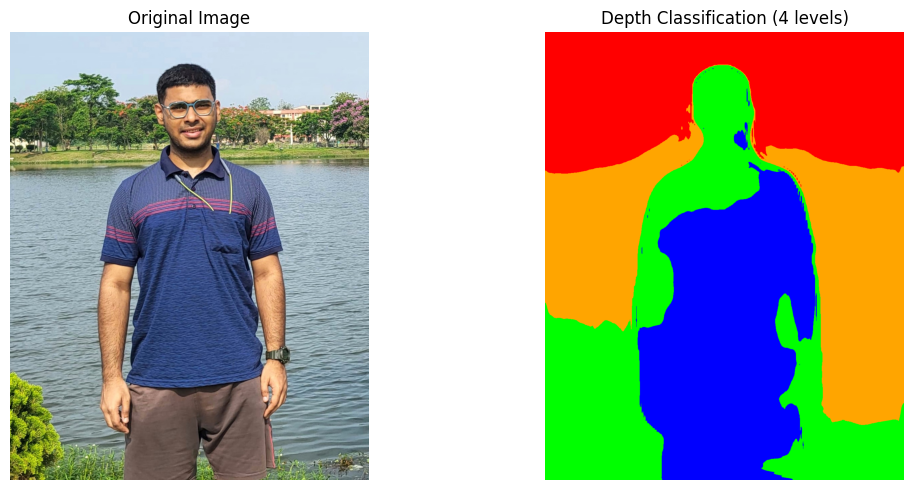

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

# Step 1: Load MiDaS Small (fast & lightweight model)
model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small", trust_repo=True)
model.to("cuda" if torch.cuda.is_available() else "cpu").eval()

# Load the correct preprocessing pipeline
transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True)
transform = transforms.small_transform

# Step 2: Upload an image
uploaded = files.upload()
image_path = next(iter(uploaded))
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)

# Step 3: Prepare the image for the model
input_tensor = transform(image_np).to("cuda" if torch.cuda.is_available() else "cpu")

# Step 4: Predict depth
with torch.no_grad():
    prediction = model(input_tensor)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=image.size[::-1],  # (width, height)
        mode="bicubic",
        align_corners=False,
    ).squeeze()

# Step 5: Normalize depth map to 0–1
depth = prediction.cpu().numpy()
depth_normalized = (depth - depth.min()) / (depth.max() - depth.min())

# Step 6: Convert depth to 4 categories: very near, near, far, very far
# We'll use percentiles to keep the classes balanced
thresholds = np.quantile(depth_normalized, [0.25, 0.5, 0.75])
depth_classes = np.digitize(depth_normalized, thresholds)  # Outputs: 0 to 3

# Step 7: Assign a color to each class
colors = np.array([
    [255, 0, 0],      # Very Near – Red
    [255, 165, 0],    # Near – Orange
    [0, 255, 0],      # Far – Green
    [0, 0, 255]       # Very Far – Blue
], dtype=np.uint8)

# Step 8: Create a color image from the class map
colored_depth = colors[depth_classes]
Image.fromarray(colored_depth).save("depth_classified.png")

# Step 9: Show results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Depth Classification (4 levels)")
plt.imshow(colored_depth)
plt.axis("off")

plt.tight_layout()
plt.show()